# Integration with Ubermag (demo)

## Introduction and requirements

This is a tutorial to show how our MPI CPU-parallelised checkerboard algorithm can be used with Ubermag!

To be able to use this notebook, you must have followed the instruction steps 1 to 3 in the project README. 
In short, if you have Python, C++ 11, and MPI are installed, make a new virtual environment and run the following from the `CPUMag` directory:

```
pip install cython
pip install matplotlib
pip install numpy
pip install discretisedfield
pip install micromagneticmodel
pip install oommfc
python setup.py build_ext --inplace
```
where the last two lines build the Cython extension and install the custom Python package that wraps its functionality.

## Simulation!
Now let's start simulating! First import packages and define some generic physical and magnetic parameters.

In [1]:
# Imports
import numpy as np
import micromagneticmodel as mm
import discretisedfield as df
import oommfc as oc
from matplotlib import pyplot as plt

#plt.rcParams["text.usetex"] = True
%matplotlib inline

# If Ubermag cannot be installed fully, install mm, df, and oc and use this Docker image:
docker_runner = oc.oommf.DockerOOMMFRunner(image="ubermag/oommf")

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Define generic physical, magnetic, and flag parameters
T = 0.0
Ms = 384e3
atomistic = False

## Example 1/3: Zeeman interaction

Let's first reproduce expected results for the Zeeman interaction a small system.

In [4]:
Nx, Ny, Nz = 3, 3, 3  # Small system
Lx, Ly, Lz = 50e-9, 50e-9, 50e-9
H = (0, 0, 5.5e5)

# Create a Zeeman system
zeeman_system = mm.System(name="zeeman_system")

# System size and mesh
region = df.Region(p1=(0, 0, 0), p2=(Lx, Ly, Lz))
mesh = df.Mesh(region=region, n=(Nx, Ny, Nz))
zeeman_system.m = df.Field(mesh, dim=3, value=(1, 0, 0), norm=Ms)

# System energy
zeeman_system.energy = mm.Zeeman(H=H)

Now we simply drive the system object with out driver! Under the hood, a Python script in `CPUsimPy` extracts the values from the system object, puts them as arguments into a C++ code via a shared object, reads the results from file, and puts these values into the system object.

For now, it is not possible to input specific initialisation arrays into the driver, although the driver function allows uses to choose between four initilisation states:

0. Random initialisation
1. Unit $x$ initialisation
2. Unit $y$ initialisation
3. Unit $z$ initialisation

Let's run our system with just the Zeeman interaction.

In [ ]:
from CPU_driver import driver, plot_quiver, plot_energy_data, read_data_file

# Driver variables
p = 1
atomistic = False  # Continuous interpretation
init_status = 0
it_max = 1e4
alpha_decay = False  # No decreasing search-cone

# Drive the system
driver(
    zeeman_system,
    p,
    atomistic=atomistic,
    init_status=init_status,
    it_max=it_max,
    alpha_decay=alpha_decay,
)

# Visualise
plot_quiver("out/mu_init.dat")
plot_quiver("out/mu_end.dat")
plot_energy_data("out/energy_data.dat")
_, zeeman_energy_1 = read_data_file("out/energy_data.dat")

Now let's increase $p$ and see  the effect it has on the energy curve.

2 process(es) used ...
MPI_AtomData custom datatype successfully created...
Iteration 1000 reached ...
Iteration 2000 reached ...
Iteration 3000 reached ...
Iteration 4000 reached ...
Iteration 5000 reached ...
Iteration 6000 reached ...
Iteration 7000 reached ...
Iteration 8000 reached ...
Iteration 9000 reached ...
Iteration 10000 reached ...
Maximum number of iterations reached after 20000 updates ...
With 2 processes on a 5 x 5 x 5 system the simulation took 0.00760171s to run ...

Saving results to file ...
Simulation complete!


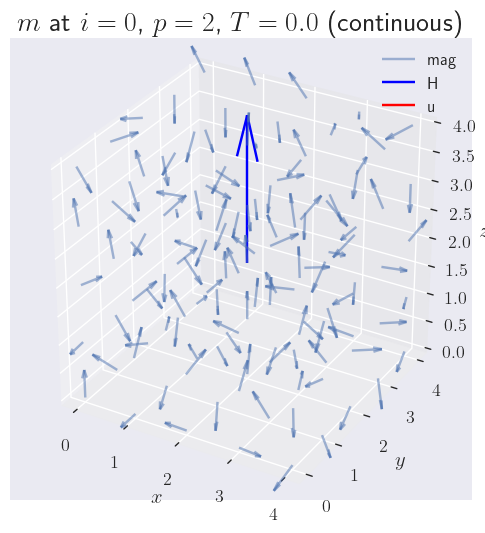

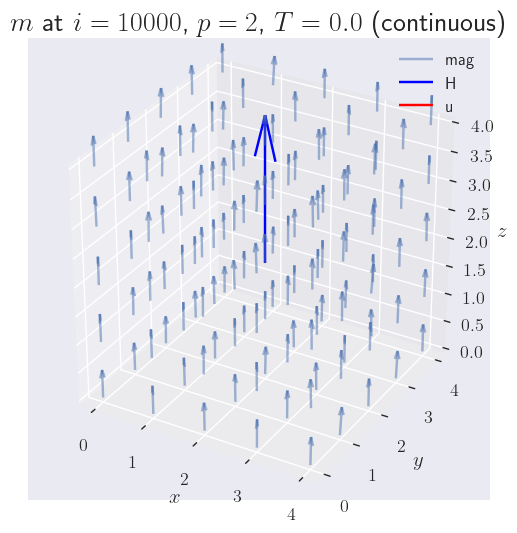

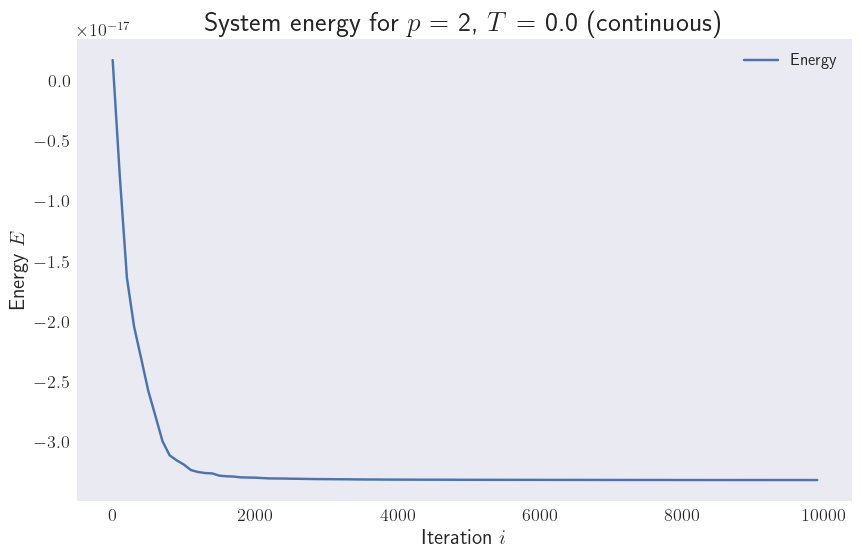

In [99]:
p = 2

# Drive the system
driver(
    zeeman_system,
    p,
    atomistic=atomistic,
    init_status=init_status,
    it_max=it_max,
    alpha_decay=alpha_decay,
)

# Visualise
plot_quiver("out/mu_init.dat")
plot_quiver("out/mu_end.dat")
plot_energy_data("out/energy_data.dat")
_, zeeman_energy_2 = read_data_file("out/energy_data.dat")

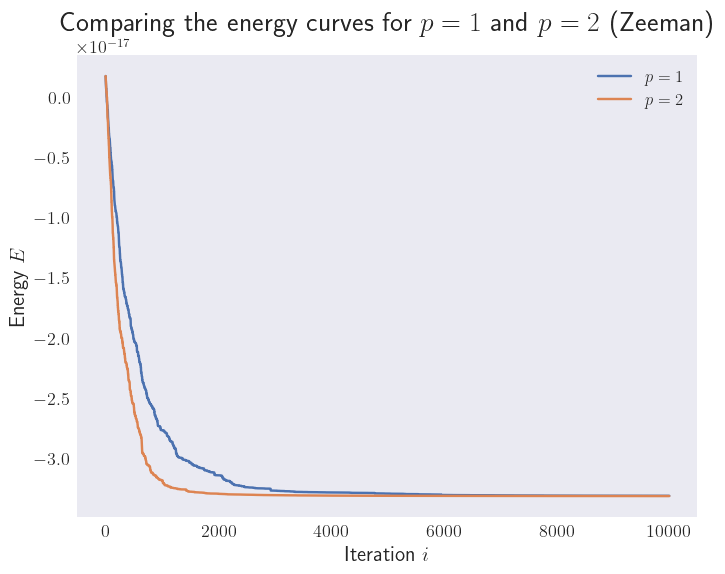

In [101]:
plt.plot(zeeman_energy_1, label=r"$p=1$")
plt.plot(zeeman_energy_2, label=r"$p=2$")
plt.xlabel(r"Iteration $i$")
plt.ylabel(r"Energy $E$")
plt.title(r"Comparing the energy curves for $p=1$ and $p=2$ (Zeeman)")
plt.legend();

We can see that the simulation stops evolving twice as soon in terms of iterations. This is because the number of updates per iteration has doubled.

## Example 2/3: Anisotropy and exchange

Setting anisotropy axis and positive $K$, we will show that with negative $A$, the magnetisations will align with $\hat{\boldsymbol{u}}$ and alterate as parallel and antiparallel to it (mostly).

In [126]:
Nx, Ny, Nz = 5, 5, 5  # Small system
Lx, Ly, Lz = 50e-9, 50e-9, 50e-9
u = (1, 0, 0)
K = 45e4
J = -8.78e-12

# Create a system with exchagne and anisotropy
anisotropy_exchange_system = mm.System(name="anisotropy_zeeman_system")

# System size and mesh
region = df.Region(p1=(0, 0, 0), p2=(Lx, Ly, Lz))
mesh = df.Mesh(region=region, n=(Nx, Ny, Nz))
anisotropy_exchange_system.m = df.Field(mesh, dim=3, value=(0, 1, 0), norm=Ms)

# System energy
anisotropy_exchange_system.energy = mm.UniaxialAnisotropy(K=K, u=u) + mm.Exchange(A=J)

2 process(es) used ...
MPI_AtomData custom datatype successfully created...
Iteration 10000 reached ...
Iteration 20000 reached ...
Iteration 30000 reached ...
Iteration 40000 reached ...
Iteration 50000 reached ...
Iteration 60000 reached ...
Iteration 70000 reached ...
Iteration 80000 reached ...
Iteration 90000 reached ...
Iteration 100000 reached ...
Maximum number of iterations reached after 200000 updates ...
With 2 processes on a 5 x 5 x 5 system the simulation took 0.06775s to run ...

Saving results to file ...
Simulation complete!


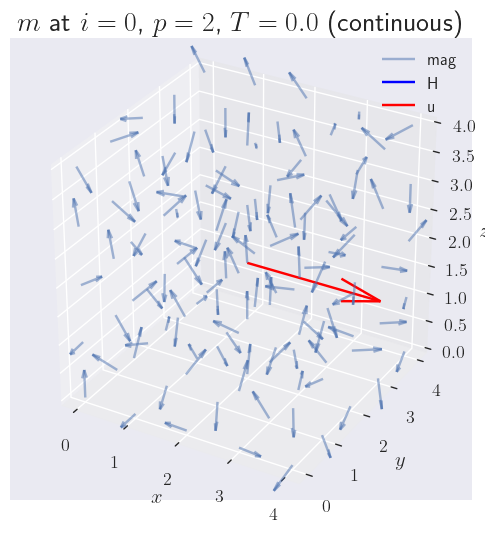

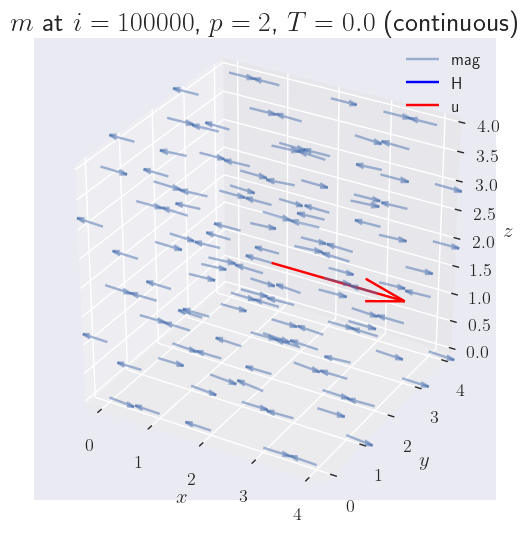

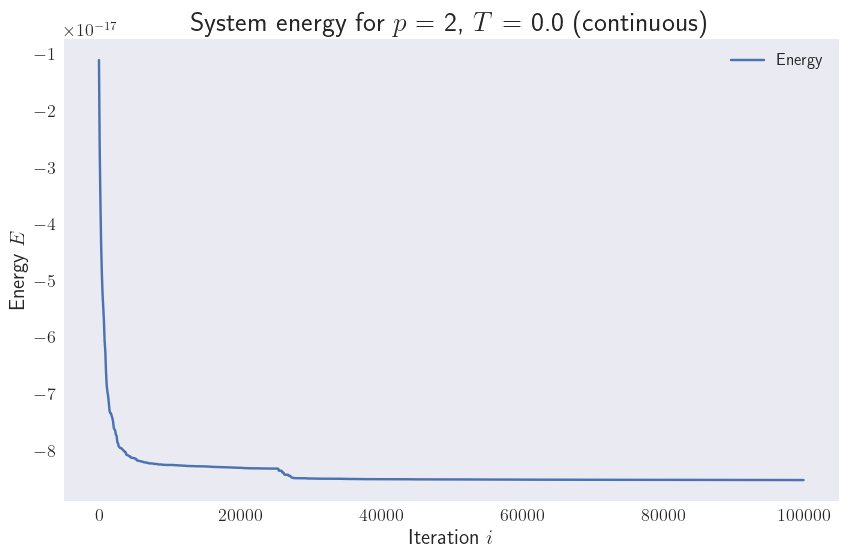

In [127]:
p = 2
it_max = 1e5

# Drive the system
driver(
    anisotropy_exchange_system,
    p,
    atomistic=atomistic,
    init_status=init_status,
    it_max=it_max,
    alpha_decay=alpha_decay,
)

# Visualise
plot_quiver("out/mu_init.dat")
plot_quiver("out/mu_end.dat")
plot_energy_data("out/energy_data.dat")

There can be quite a lot of "magnetic frustration" in this case because spins may need to "flip" in order to provide a less energetic state.

## Example 3/3: DMI twist

To demonstarate the DMI, we set-up a one-dimensional nano-wire and show that the magnetisations spiral around it at $90^{\circ}$ angles.

In [131]:
Nx, Ny, Nz = 1, 10, 1  # One-dimensional "wire"
Lx, Ly, Lz = 100e-9, 100e-9, 100e-9

D = -1.58e-3

# Create a system with DMI
dmi_system = mm.System(name="dmi_system")

# System size and mesh
region = df.Region(p1=(0, 0, 0), p2=(Lx, Ly, Lz))
mesh = df.Mesh(region=region, n=(Nx, Ny, Nz))
dmi_system.m = df.Field(mesh, dim=3, value=(1, 0, 0), norm=Ms)

# System energy
dmi_system.energy = mm.DMI(D=D, crystalclass="T")

2 process(es) used ...
MPI_AtomData custom datatype successfully created...
Iteration 10000 reached ...
Iteration 20000 reached ...
Iteration 30000 reached ...
Iteration 40000 reached ...
Iteration 50000 reached ...
Iteration 60000 reached ...
Iteration 70000 reached ...
Iteration 80000 reached ...
Iteration 90000 reached ...
Iteration 100000 reached ...
Maximum number of iterations reached after 200000 updates ...
With 2 processes on a 1 x 10 x 1 system the simulation took 0.0804268s to run ...

Saving results to file ...
Simulation complete!


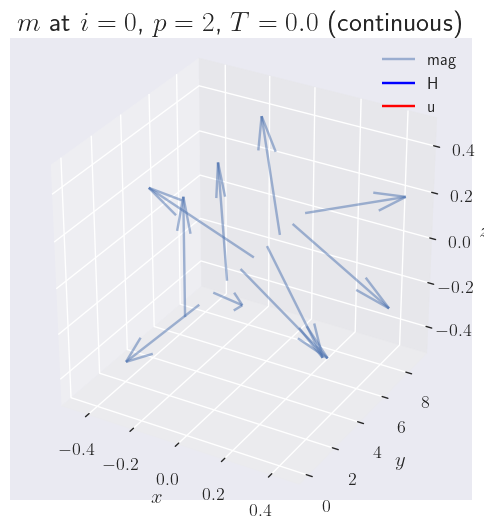

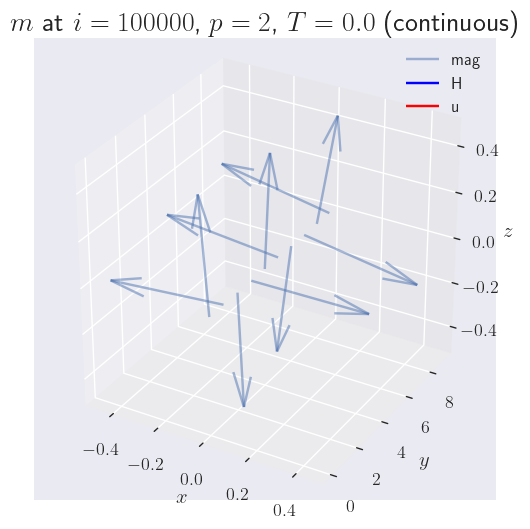

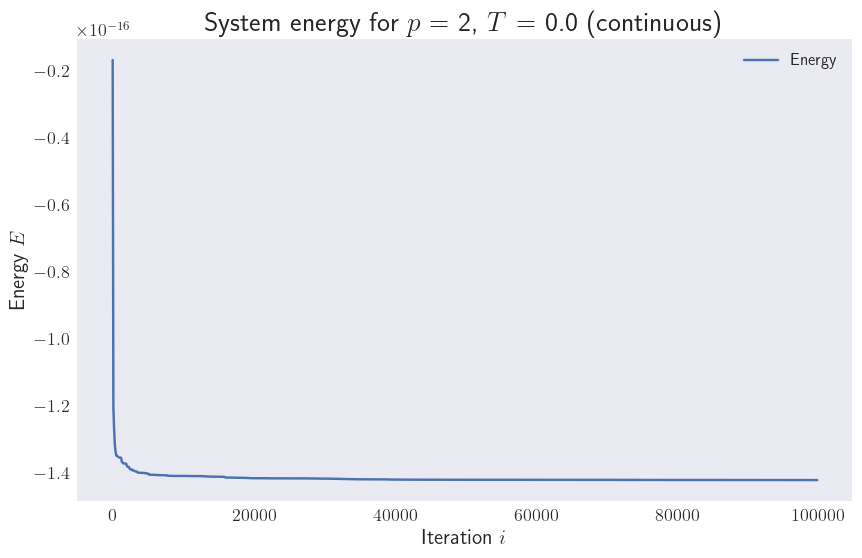

y-components of consecutive cross products are all negative 
 => Anticlockwise clockwise twist in increasing y


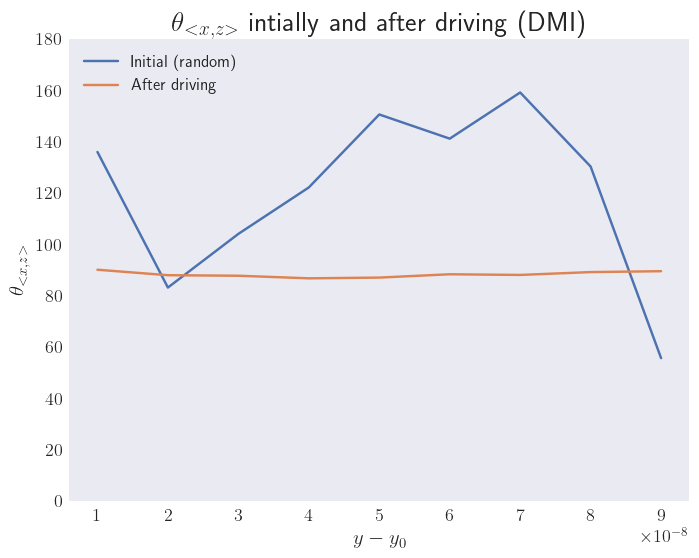

In [132]:
p = 2
it_max = 1e5

# Drive the system
driver(
    dmi_system,
    p,
    atomistic=atomistic,
    init_status=init_status,
    it_max=it_max,
    alpha_decay=alpha_decay,
)

# Visualise
plot_quiver("out/mu_init.dat")
plot_quiver("out/mu_end.dat")
plot_energy_data("out/energy_data.dat")
_, dmi_mag_init = read_data_file("out/mu_init.dat")
_, dmi_mag_end = read_data_file("out/mu_end.dat")

# Visualise angles between magnetisations
angles_init = []
angles_end = []
cross = []
for i in range(Ny - 1):
    angles_init.append(
        np.rad2deg(np.arccos(np.dot(dmi_mag_init[0, i, 0], dmi_mag_init[0, i + 1, 0])))
    )
    angles_end.append(
        np.rad2deg(np.arccos(np.dot(dmi_mag_end[0, i, 0], dmi_mag_end[0, i + 1, 0])))
    )    
    cross.append(
        np.cross(dmi_mag_end[0, i, 0], dmi_mag_end[0, i + 1, 0])[1]
    )
if np.all(np.array(cross) > 0):
    print("y-components of consecutive cross products are all positive \n => Clockwise twist in increasing y")
if np.all(np.array(cross) < 0):
    print("y-components of consecutive cross products are all negative \n => Anticlockwise clockwise twist in increasing y")
plt.plot(np.arange(1, Ny) * (Ly / Ny), angles_init, label="Initial (random)")
plt.plot(np.arange(1, Ny) * (Ly / Ny), angles_end, label="After driving")
plt.xlabel(r"$y - y_0$")
plt.ylabel(r"$\theta_{<x, z>}$")
plt.ylim(0, 180)
plt.title(r"$\theta_{<x, z>}$ intially and after driving (DMI)")
plt.legend();

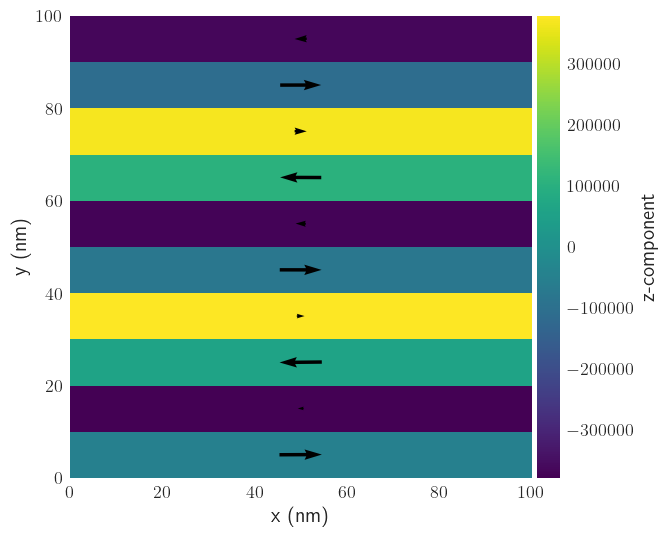

In [130]:
dmi_system.m.plane(z=0e-9).mpl()